In [1]:
import os
import glob

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from dynamic_routing_analysis import decoding_utils, plot_utils
import dynamic_routing_analysis as dra

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# set path to decoding results
loadpath = dra.DECODING_ROOT_PATH / "new_annotations" / "linear_shift_20_units"
files=glob.glob(os.path.join(loadpath,'*_decoding_results*.pkl'))

In [2]:
# load all trialwise decoding results, option to concatenate all sessions
concat_session_results=False
save_tables=False
return_table=False
# loadpath = (
#     dra.DECODING_ROOT_PATH
#     / "new_annotations"
#     / "linear_shift_20_units"
#     / "combined" 
#     / "no_normalization"
# )
loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\shailaja\population_decoding"
if save_tables:
    savepath=loadpath
else:
    savepath=None

if concat_session_results:
    combined_results=decoding_utils.concat_trialwise_decoder_results(files,savepath=savepath,return_table=return_table)
    if return_table:
        decoder_confidence_versus_response_type=combined_results[0]
        decoder_confidence_dprime_by_block=combined_results[1]
        decoder_confidence_by_switch=combined_results[2]
        decoder_confidence_versus_trials_since_rewarded_target=combined_results[3]
        decoder_confidence_before_after_target=combined_results[4]
else:
    decoder_confidence_versus_response_type=pd.read_csv(os.path.join(loadpath,'decoder_confidence_versus_response_type.csv'))
    decoder_confidence_dprime_by_block=pd.read_csv(os.path.join(loadpath,'decoder_confidence_dprime_by_block.csv'))
    decoder_confidence_by_switch=pd.read_csv(os.path.join(loadpath,'decoder_confidence_by_switch.csv'))
    decoder_confidence_versus_trials_since_rewarded_target=pd.read_csv(os.path.join(loadpath,'decoder_confidence_versus_trials_since_rewarded_target.csv'))
    decoder_confidence_before_after_target=pd.read_csv(os.path.join(loadpath,'decoder_confidence_before_after_target.csv'))

## plot correct reject minus false alarm decoder confidence across areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18124\1287702840.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18124\1287702840.py:29: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18124\1287702840.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))
C:\Users\eth

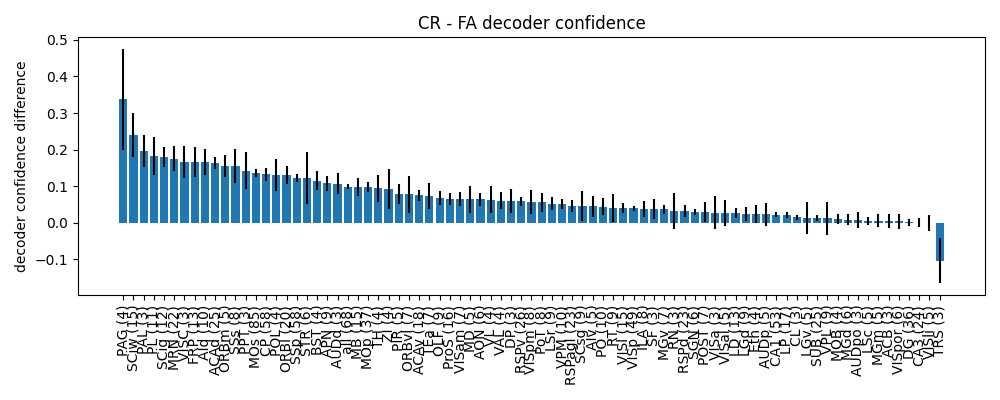

In [3]:
sel_project='DynamicRouting'
min_n_sessions=3
min_n_good_blocks=4

cr_fa_diff_by_area={
    'area':[],
    'n_sessions':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    'total_diff':[],
}

for aa in decoder_confidence_versus_response_type['area'].unique():
    
    sel_area=decoder_confidence_versus_response_type.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
    cr_fa_diff_by_area['area'].append(aa)
    cr_fa_diff_by_area['n_sessions'].append(len(sel_area))
    cr_fa_diff_by_area['vis_context_dprime'].append(np.mean(sel_area['vis_context_dprime']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff'].append(np.mean(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
    cr_fa_diff_by_area['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_area['vis_cr_confidence']-sel_area['vis_fa_confidence']))
    cr_fa_diff_by_area['aud_context_dprime'].append(np.mean(sel_area['aud_context_dprime']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff'].append(np.mean(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
    cr_fa_diff_by_area['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_area['aud_cr_confidence']-sel_area['aud_fa_confidence']))
    cr_fa_diff_by_area['mean_diff'].append(np.mean([cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1],-cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1]]))

    mean_diffs=(sel_area['vis_cr_confidence'].values+sel_area['aud_cr_confidence'].values)/2-(sel_area['vis_fa_confidence'].values+sel_area['aud_fa_confidence'].values)/2
    cr_fa_diff_by_area['mean_diff_sem'].append(stats.sem(mean_diffs))

    cr_fa_diff_by_area['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_area['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_area['aud_context_cr_fa_diff'][-1])]))


cr_fa_diff_by_area=pd.DataFrame(cr_fa_diff_by_area)

plot_data=cr_fa_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(10,4))
ax.bar(plot_data['area'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('decoder confidence difference')

ax.set_title('CR - FA decoder confidence')

fig.tight_layout()


## correct - incorrect decoder confidence across areas

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18124\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18124\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18124\573162211.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  correct_incorrect_diff_by_area['correct_incorrect

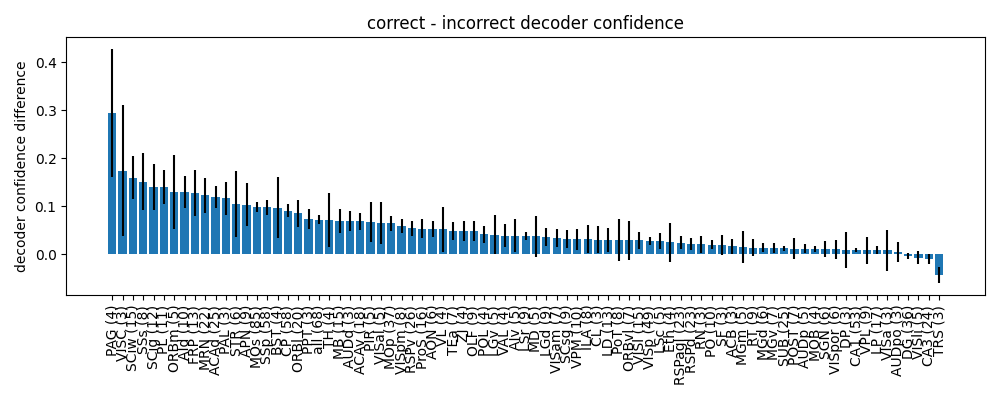

In [4]:
sel_project='DynamicRouting'
min_n_sessions=3
min_n_good_blocks=4

correct_incorrect_diff_by_area={
    'area':[],
    'n_sessions':[],
    'dprime':[],
    'correct_incorrect_diff':[],
    'correct_incorrect_diff_sem':[],

}

for aa in decoder_confidence_versus_response_type['area'].unique():
    sel_area=decoder_confidence_versus_response_type.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
    correct_incorrect_diff_by_area['area'].append(aa)
    correct_incorrect_diff_by_area['n_sessions'].append(len(sel_area))
    correct_incorrect_diff_by_area['dprime'].append(np.mean(sel_area['overall_dprime']))
    correct_incorrect_diff_by_area['correct_incorrect_diff'].append(np.mean(sel_area['correct_confidence']-sel_area['incorrect_confidence']))
    correct_incorrect_diff_by_area['correct_incorrect_diff_sem'].append(stats.sem(sel_area['correct_confidence']-sel_area['incorrect_confidence']))

correct_incorrect_diff_by_area=pd.DataFrame(correct_incorrect_diff_by_area)

plot_data=correct_incorrect_diff_by_area.query('n_sessions>=@min_n_sessions').sort_values(by='correct_incorrect_diff',ascending=False)

fig,ax=plt.subplots(figsize=(10,4))
ax.bar(plot_data['area'],plot_data['correct_incorrect_diff'],yerr=plot_data['correct_incorrect_diff_sem'])

area_labels=[]
for i in range(plot_data.shape[0]):
    area_labels.append(plot_data['area'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(area_labels,rotation=90,ha='center')
ax.set_ylabel('decoder confidence difference')
ax.set_title('correct - incorrect decoder confidence')

fig.tight_layout()


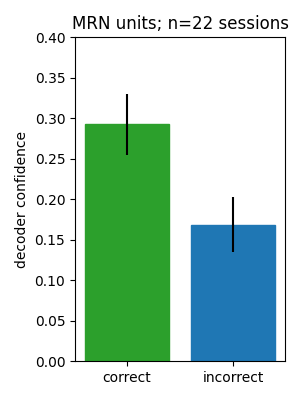

In [11]:
#correct vs. incorrect

#select area
aa='MRN'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area=decoder_confidence_versus_response_type.query('area==@aa and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(3,4))
ax.axhline(0,color='k',linewidth=0.5)
bars=ax.bar([0,1],sel_area[['correct_confidence','incorrect_confidence',]].mean().values)
ax.errorbar([0,1],sel_area[['correct_confidence','incorrect_confidence']].mean().values,
            yerr=sel_area[['correct_confidence','incorrect_confidence',]].sem().values,linestyle='',color='k')
ax.set_xticks([0,1])
ax.set_xticklabels(['correct','incorrect'])
bars[0].set_color('tab:green')
bars[1].set_color('tab:blue')

ax.set_title(str(aa)+' units; n='+str(len(sel_area))+' sessions')
ax.set_ylim([0,0.4])
ax.set_ylabel('decoder confidence')
fig.tight_layout()

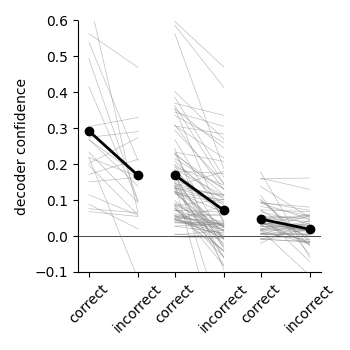

In [37]:
#compare multiple areas

area1='MRN'
area2='MOs'
area3='VISp'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area1=decoder_confidence_versus_response_type.query('area==@area1 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
sel_area2=decoder_confidence_versus_response_type.query('area==@area2 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')
sel_area3=decoder_confidence_versus_response_type.query('area==@area3 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(3.5,3.5))
ax.axhline(0,color='k',linewidth=0.5)

ax.plot([0,1],[sel_area1['correct_confidence'],sel_area['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([0,1],[sel_area1['correct_confidence'].mean(),sel_area1['incorrect_confidence'].mean()],'k-o',linewidth=2)
ax.plot([1.75,2.75],[sel_area2['correct_confidence'],sel_area2['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([1.75,2.75],[sel_area2['correct_confidence'].mean(),sel_area2['incorrect_confidence'].mean()],'k-o',linewidth=2)
ax.plot([3.5,4.5],[sel_area3['correct_confidence'],sel_area3['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([3.5,4.5],[sel_area3['correct_confidence'].mean(),sel_area3['incorrect_confidence'].mean()],'k-o',linewidth=2)

ax.set_xticks([0,1,1.75,2.75,3.5,4.5])
ax.set_xticklabels(['correct','incorrect','correct','incorrect','correct','incorrect'],rotation=45)

ax.set_ylabel('decoder confidence')

#remove spines
ax.set_ylim([-0.1,0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

In [39]:
#save figure
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-09-25-plots_for_SFN_poster"
fig.savefig(os.path.join(savepath,area1+'_'+area2+'_'+area3+'_decoder_confidennce.png'),format='png',dpi=600)

In [27]:
sel_area1

,session,area,project,vis_context_dprime,vis_hit_confidence,vis_fa_confidence,vis_cr_confidence,aud_context_dprime,aud_hit_confidence,aud_fa_confidence,...,n_good_blocks,correct_confidence,incorrect_confidence,cr_all_confidence,fa_all_condfidence,hit_all_confidence,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,n_units
17,626791_2022-08-15,all,DynamicRouting,2.974365,0.051861,0.026056,0.062851,1.991225,-0.048705,-0.106164,...,5,0.063385,0.070371,0.092562,0.070371,0.050378,6736.041155,3034.597666,3740.540541,1628
24,626791_2022-08-16,all,DynamicRouting,2.417437,0.004269,0.047865,-0.012279,1.240016,0.015484,-0.015406,...,4,-0.004846,0.031122,-0.004751,0.033227,-0.004885,8490.356490,2454.844607,3151.599634,554
56,636766_2023-01-23,all,DynamicRouting,3.166625,0.061604,0.006193,0.094910,0.533664,-0.029791,-0.054529,...,5,0.062891,0.029861,0.092819,0.033986,0.045894,5942.835596,3018.759427,3386.972097,1326
71,636766_2023-01-24,all,DynamicRouting,-0.887147,0.057116,0.021365,0.052835,3.110150,-0.082140,-0.001987,...,5,0.068896,0.025024,0.063881,0.013347,0.072592,5388.391225,3097.052102,3348.834552,1094
90,636766_2023-01-25,all,DynamicRouting,1.728227,0.096163,0.010733,0.099038,2.368659,-0.059154,-0.031564,...,5,0.077096,0.018868,0.076863,0.022636,0.077218,6738.352490,2297.586207,4138.793103,1306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,715710_2024-07-16,all,DynamicRouting,0.588274,0.111679,0.018908,0.155463,2.220148,-0.139616,-0.118890,...,5,0.121543,0.027682,0.116284,0.059642,0.125812,5523.625498,3482.410359,3013.406375,1255
1548,715710_2024-07-17,all,DynamicRouting,3.180604,0.107136,-0.166121,0.179832,1.446927,-0.169616,-0.285456,...,5,0.160146,0.077252,0.189348,0.172562,0.131276,7484.917921,3119.493844,3794.254446,731
1568,715710_2024-07-18,all,DynamicRouting,2.085625,0.029416,0.032955,0.065077,1.762035,-0.026752,-0.044045,...,5,0.040211,0.027132,0.056633,0.038153,0.028130,3738.363363,3556.971257,4173.798799,2333
1582,715710_2024-07-19,all,DynamicRouting,2.003943,0.047867,0.034577,0.052610,1.834303,-0.041547,-0.018507,...,5,0.037162,0.024069,0.025123,0.027307,0.045001,5324.934297,3272.568988,2637.992773,1522


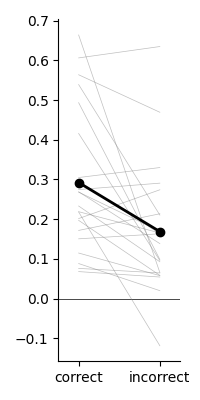

In [31]:
##compare multiple areas

area1='MRN'

sel_project='DynamicRouting'
min_n_recs=3
min_n_good_blocks=4

sel_area1=decoder_confidence_versus_response_type.query('area==@area1 and n_good_blocks>=@min_n_good_blocks and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(2,4))
ax.axhline(0,color='k',linewidth=0.5)

ax.plot([0,1],[sel_area1['correct_confidence'],sel_area1['incorrect_confidence']],'grey',alpha=0.5,linewidth=0.5)
ax.plot([0,1],[sel_area1['correct_confidence'].mean(),sel_area1['incorrect_confidence'].mean()],'k-o',linewidth=2)

ax.set_xticks([0,1])
ax.set_xticklabels(['correct','incorrect'])

# bars=ax.bar([0,1,2],np.array([sel_area1['correct_confidence'].mean(),sel_area2['correct_confidence'].mean(),sel_area3['correct_confidence'].mean()]))
# ax.errorbar([0,1,2],np.array([sel_area1['correct_confidence'].mean(),sel_area2['correct_confidence'].mean(),sel_area3['correct_confidence'].mean()]),
#             yerr=np.array([sel_area1['correct_confidence'].sem(),sel_area2['correct_confidence'].sem(),sel_area3['correct_confidence'].sem()]),linestyle='',color='k')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels([area1,area2,area3])
# bars[0].set_color('tab:green')
# bars[1].set_color('tab:blue')
# bars[2].set_color('tab:orange')

# ax.set_title('correct decoder confidence')

#remove spines
# ax.set_ylim([-0.2,0.6])
ax.set_xlim(-0.25,1.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

In [7]:
##TODO: plot/validate other trialwise analyses